# Classical and quantum simulations of control over temporal correlations

### This code reproduces Fig. 4 for both the classical or the ibm_oslo quantum simulator.

In [1]:
import qiskit
import matplotlib.pyplot as plt
import numpy as np

from src import collision_hamiltonian, collision_unitary, GeneralTimeDependentDoob, calculate_full_counting_statistics_functional, correlation_specs, analyse_observable_histogram_functional, simulate_quantum_circuits

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table

In [3]:
# standard values
__omega = 1
__kappa = 1
NTRAJ = 20000  # max. free shots on QPC
line_colors = ['b', 'k', 'r']
marker = {'classical': '+', 'quantum': r'$\circ$'}

# calculate collisions hamiltonian and unitary
unbiased_hamiltonian = collision_hamiltonian(omega=__omega, kappa=__kappa)
unbiased_unitary = collision_unitary(hamiltonian=unbiased_hamiltonian)

Do calculations with 
1) a classical or quantum simulator
2) new data or already existing one 

In [4]:
# data of Fig. 4 in 'quantum' and '000002' respectively 'classical' and '000003'
simulator_type = "quantum"
data_no = "000002"  # use None for new calculations

# general settings
NCOLL = 3
s_vals = np.linspace(-1, 1, 3)
correlation_obs_spec = correlation_specs(NCOLL=NCOLL)

# iterate through s_vals and 1) calculate exact biased prob., 2) get the quantum circuits possibly needed for the sim., 3) plot them 
fig4, axs4 = plt.subplots(nrows=2)
qc_to_simulate = []
for s_ind in range(s_vals.size):
    DoobObj = GeneralTimeDependentDoob(collision_unitary=unbiased_unitary, observable_specs=correlation_obs_spec,
                                           s_val=s_vals[s_ind])
    # exact probabilities
    fcs = calculate_full_counting_statistics_functional(Kraus_list=DoobObj.get_undoobed_Kraus_ops(),
                                                        observable_specs=correlation_obs_spec, s_val=s_vals[s_ind])
    opd = analyse_observable_histogram_functional(full_counting_statistics=fcs,
                                                    observable_specs=correlation_obs_spec)

    # plot "energy"-values
    axs4[0].fill_between(opd.index, 
                        opd['$P_s(O)$'], 
                        color=line_colors[s_ind], alpha=.4)

    # plot full counting statistics
    axs4[1].fill_between(np.arange(fcs.index.size),
                        fcs, 
                        color=line_colors[s_ind], alpha=0.4, label=f'$s={s_vals[s_ind]:.0f}$')

    axs4[1].set_xticks(np.arange(fcs.index.size), fcs.index, rotation=45)

    # prepare for sim
    qc_to_simulate.append(DoobObj.get_doobed_quantum_circuit(name=f's={s_vals[s_ind]:.0f}'))
    
plt.close()


quickly plot one of the quantum circuits before simulating all of them at once (saves time on QPC)

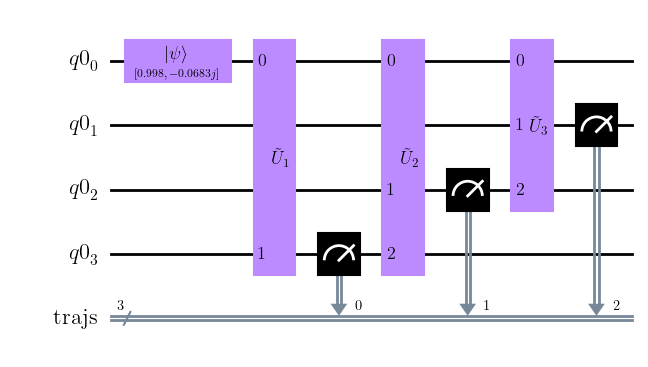

In [5]:
qc_to_simulate[0].draw(output='mpl')

In [6]:
if not data_no:  # -> calculate new data according to next number in simulations
    simulate_quantum_circuits(qc_stack=qc_to_simulate, NTRAJ=NTRAJ, how='simulator', backend_name='None')

    #  get simulations name just calculated
    with open(f'src/number_of_{simulator_type}_simulations.txt', 'r+') as file:
        current_sim_number = file.read()
        number = int(current_sim_number)

        preceding_number = ''
        for _ in range(6 - len(list(str(number - 1)))):
            preceding_number += '0'
        preceding_number += str(number - 1)

    data_filename = simulator_type + '_sim_' + preceding_number
    
else:
    data_filename = simulator_type + '_sim_' + data_no

read in Data with GeneralTimeDependentDoob-class and plot the results

In [7]:
for s_ind in range(s_vals.size):
        DoobObj = GeneralTimeDependentDoob(collision_unitary=unbiased_unitary, observable_specs=correlation_obs_spec,
                                           s_val=s_vals[s_ind])
        DoobObj.set_simulation_parameters(NTRAJ=NTRAJ, method='from_hdf5_' + data_filename)
        
        # 'energy'-values
        sim_results = DoobObj.analyse_observable_histogram(experiment_name=f's={s_vals[s_ind]:.0f}', num_resamples=20)

        axs4[0].errorbar(DoobObj.get_possible_observable_values(),
                                          # + s_vals[s_ind] * observable_width,
                                          sim_results[0],  # [sim_results[1], sim_results[2]],
                                          marker=marker[simulator_type], linestyle='None',
                                          c=line_colors[s_ind], markersize=4)

        # full counting statistics
        sim_results = DoobObj.analyse_full_counting_statistics(
            experiment_name=f's={s_vals[s_ind]:.0f}', num_resamples=20)

        axs4[1].errorbar(np.arange(sim_results[0].index.size),  # + s_vals[s_ind] * traj_width,
                                          sim_results[0],  # [sim_results[1], sim_results[2]],
                                          marker=marker[simulator_type], linestyle='None',
                                          c=line_colors[s_ind], markersize=4)

Do some explanations and show the final result 

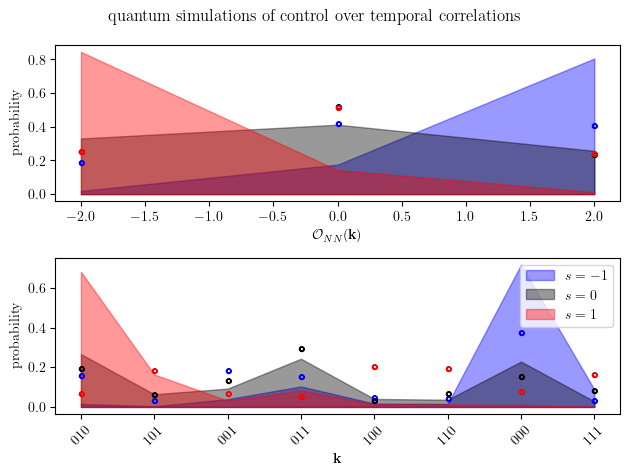

In [8]:
fig4.suptitle(f'{simulator_type} simulations of control over temporal correlations')

axs4[0].set_xlabel(r'$\mathcal{O}_{NN}(\mathbf{k})$')
axs4[1].legend()
axs4[1].set_xlabel(r'$\mathbf{k}$')
for ax in axs4:
    ax.set_ylabel('probability')

fig4.tight_layout()
fig4